In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Close any open database session.
# db.close()

# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [8]:
postgres.raw_sql("""
SELECT * FROM paper_texts pt
WHERE pt.directory = 'rsc'
And pt."section" != 'abstract';
""")

[]

In [9]:
db.close()

### Parsing

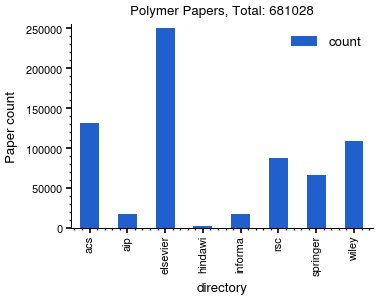

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa,17396
5,rsc,87429
6,springer,66532
7,wiley,108968


In [13]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

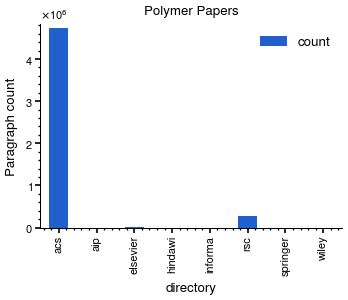

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,7044
3,hindawi,74
4,informa,24
5,rsc,281216
6,springer,74
7,wiley,239


In [94]:
df = execute("""
             SELECT directory, count(*) FROM paper_texts pt
             -- only the polymer papers
             JOIN filtered_papers fp ON fp.doi = pt.doi 
             GROUP BY directory;
""")
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title="Polymer Papers")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

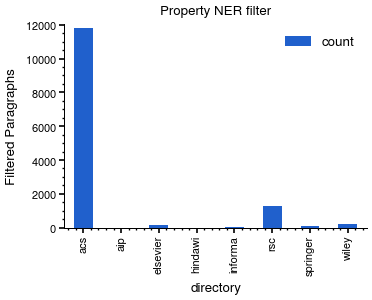

,directory,count
0,acs,11793
1,aip,2
2,elsevier,167
3,hindawi,2
4,informa,19
5,rsc,1275
6,springer,88
7,wiley,189


In [93]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_%'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'Property NER filter')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [96]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,39887


In [95]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,86887


In [41]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [81]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [78]:
def plot_histogram(df, name, unit):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', label='Total: %d' %df.shape[0], ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name}.png', dpi=600)
    plt.show()

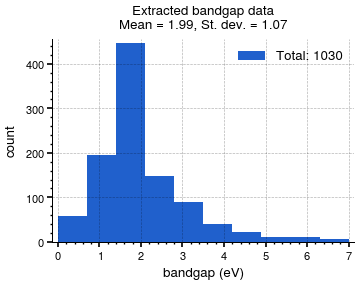

In [79]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap', 'eV')

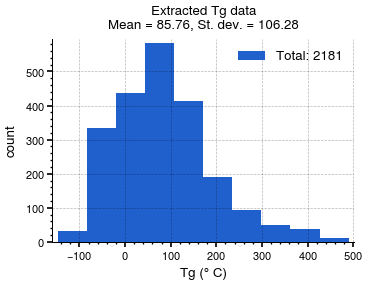

In [80]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg', '°C')

In [83]:
unit_counts(df)

unit
° C                   669
                       37
∼ ° C                  31
+ / ° C                19
° C   ° C               8
+ /                     6
° C ° C                 5
∼  ° C                  4
+ / K                   3
∼   ° C                 3
∼ K                     2
approximately  ° C      2
+/ ° C                  2
,                       2
,,,,  ° C               1
./ ° C                  1
∼  ∼ ° C                1
, ° C                   1
° C)containin           1
,,,  ° C                1
,,, ° C                 1
) °                     1
} J^{13}^{}^{}          1
x                       1
s                       1
nm^{3}                  1
negative  ° C           1
kJ mol^{-1} K^{-1}      1
g/mol                   1
delineated  ° C         1
+ / J/(g K)             1
( + /) x                1
M̄_{n}^{a}              1
MPa                     1
:                       1
3 ° C                   1
/ ° C                   1
[Li                     1
Name: n

In [49]:
df = execute("select * from property_metadata")
df

,name,other_names,units,scale,short_name,lower_limit,upper_limit,id,date_added
0,gravimetric energy density,[energy density],"[Wh kg^{-1}, W h kg^{-1}, Wh/kg, Wh*kg^{-1}, W...",normal,None,0.0,1000.0,1,2023-09-13 16:59:45.748486-04:00
1,gravimetric power density,[power density],"[W kg^{-1}, kW kg^{-1}, W/kg, kW/kg, W Kg^{-1}...",normal,None,0.0,120000.0,2,2023-09-13 16:59:45.757140-04:00
2,specific capacitance,"[capacitance, specific capacitance]","[F g^{-1}, F/g, Fg^{-1}, F*g^{-1}, F.g^{-1}, F...",normal,None,0.0,4500.0,3,2023-09-13 16:59:45.759624-04:00
3,current density,[current density],"[A g^{-1}, A/g, mA g^{-1}, mA/g, Ag^{-1}, A*g^...",normal,None,0.0,100.0,4,2023-09-13 16:59:45.762217-04:00
4,areal current density,"[current density, areal current density]","[mA cm^{-2}, mA/cm^{2}, μA cm^{-2}, μA/cm^{2},...",normal,None,0.0,4000.0,5,2023-09-13 16:59:45.764765-04:00
...,...,...,...,...,...,...,...,...,...
77,luminance,"[brightness, luminance]","[cd/m^{2}, cd m^{-2}, cd * m^{-2}, cd*m^{-2}, ...",normal,None,0.0,800000.0,78,2023-09-13 16:59:45.979741-04:00
78,luminance efficiency,"[luminance efficiency, current efficiency]","[cd/A, cd A^{-1}, cd * A^{-1}]",normal,None,0.0,100.0,79,2023-09-13 16:59:45.982623-04:00
79,dielectric loss,[dielectric loss],[],normal,None,0.0,4.0,80,2023-09-13 16:59:45.985554-04:00
80,capacitance retention,"[capacitance retention, capacitance retention ...",[%],normal,None,0.0,100.0,81,2023-09-13 16:59:45.988403-04:00


In [97]:
db.close()